# ColdFusion
### GPR-LIDAR-FUSION
7/12/22

Query the SnowEx database to extract ground based snow depth measurements, snow pit density, GPR tracks, and Lidar point clounds where there is spatial and temporal overlap in a defined area.

Use the lidar snow depth measurements to inform the GPR density estimate to get SWE.

Test these density/SWE estimates against snowpit values

In [45]:
# Imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas
from snowexsql.db import get_table_attributes

import datetime 
from sqlalchemy import inspect
from sqlalchemy.sql import func
import shapely.geometry
from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc

# Imports for Lidar raster
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

### Define Boundingbox

In [32]:
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

### Magnaprobe Data

In [ ]:
engine, session = get_db(db_name)

# Instrument name 
site_name = "Grand Mesa"
instrument = "magnaprobe" 

# Get a session
engine, session = get_db(db_name)

# The part inside the query function is what we want back, in this case all columns for the point data
qry = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, PointData.value, 
                    PointData.type, PointData.instrument)

# Filter by site
qry = qry.filter(PointData.site_name == site_name)

# Filter by bounding box 
qry = qry.filter(gfunc.ST_Within(PointData.geom, wkb_element))

# Filter by an instrument 
qry = qry.filter(PointData.instrument == instrument) # .in_(['magnaprobe', 'pit_ruler']))

# Slicing the dataset for specified dates 
date1 = datetime.date(2020,1,29)
date2 = datetime.date(2020,2,6)
qry = qry.filter(PointData.date >= date1)
qry = qry.filter(PointData.date <= date2)

# Execute the query and convert to geopandas in one handy function
df = query_to_geopandas(qry, engine) #directly pass to geopandas dataframe
print(df.head())

# how many did we retrieve?
print(f'{len(df.index)} records returned!')

session.close()

### Snow Pit measurements

<class 'datetime.date'>
1292  Snowpit density measurements returned!

70  Snowpit density locations returned!



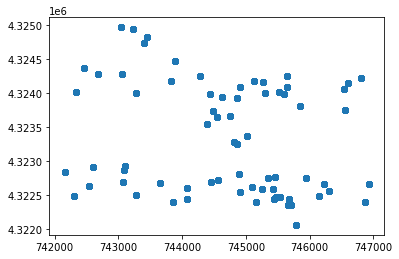

In [47]:
# Start the session
engine, session = get_db(db_name)

# Find the snowpits in the defined area within given dates
query = session.query(LayerData)
                      # .geom, LayerData.easting, LayerData.northing, LayerData.date, LayerData.value, 
                      # LayerData.pit_id, LayerData.type, LayerData.instrument)

# Filter by site (probably not needed)
# query = query.filter(LayerData.site_name == 'Grand Mesa')
# Filter by bounding box
query = query.filter(gfunc.ST_Within(LayerData.geom, wkb_element))
# Filter by type (pit density)
query = query.filter(LayerData.type == "density")
# Slicing the dataset for specified dates 
date1 = datetime.date(2020,1,29)
date2 = datetime.date(2020,2,6)
query = query.filter(LayerData.date >= date1)
query = query.filter(LayerData.date <= date2)

count = query.count() 
print(count, " Snowpit density measurements returned!\n") 

'''
# Execute the query and convert to geopandas in one handy function
df = query_to_geopandas(query, engine) #directly pass to geopandas dataframe
print(df.head())

# how many did we retrieve?
print(f'{len(df.index)} records returned!')
'''

# convert to pandas dataframe  
df = query_to_pandas(query, engine)  
# df = df.sort_values(by = ['date'])
# print(df.head())

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
locations = sorted(df['pit_id'].unique())
count = len(locations) 
print(count, " Snowpit density locations returned!\n") 


# Plot sites
plt.scatter(df['easting'], df['northing'])

session.close()

In [33]:
# Average Snowpit density measurements
# Request the average (avg) of Layer data casted as a float. We have to cast to a float in the layer table because all main values are stored as a string to
# ...accommodate the hand hardness.
qry = session.query(func.avg(LayerData.value.cast(Float)))
# Filter our query only to density
qry = qry.filter(LayerData.type=='density')
# Request the data
rho_avg_all = qry.all()
# Request the Average Density of Just 1S1
rho_avg_1s1 = qry.filter(LayerData.site_id == site_id).limit(1)
# This is a gotcha. The data in layer data only is stored as a string to accommodate the hand hardness values
print(f"Average density of all pits is {rho_avg_all[0][0]:0.0f} kg/m3")
print(f"Average density of pit 1S1 is {rho_avg_1s1[0][0]:0.0f} kg/m3")
# Cast Densities to float
rho_avg_all = float(rho_avg_all[0][0])
rho_avg_1s1 = float(rho_avg_1s1[0][0])

# Can use LayerData.pit_id to average over

NameError: name 'Float' is not defined

### GPR Data

In [5]:
# Get the GPR Dates

# Start the session
engine, session = get_db(db_name)

# Define the GPR instrument identifier
bsu_gpr_instrument_name = "pulse EKKO Pro multi-polarization 1 GHz GPR"

# Query the Pointdata to isolate by GPR instrument
query = session.query(PointData.date)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

# convert to pandas dataframe  
df = query_to_pandas(query, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
GPR_dates = sorted(df['date'].unique())

# Print the given dates
print(GPR_dates)

session.close()

[datetime.date(2020, 1, 28), datetime.date(2020, 1, 29), datetime.date(2020, 2, 4), datetime.date(2020, 2, 6), datetime.date(2020, 2, 7), datetime.date(2020, 2, 8), datetime.date(2020, 2, 9)]


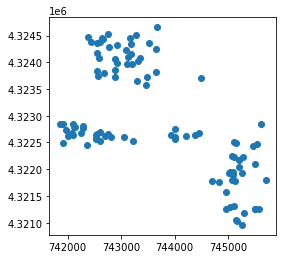

In [6]:
# Start the session
engine, session = get_db(db_name)

# Limit the size of the GPR data for initial processing and plot
query = session.query(PointData)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)
query = query.distinct().order_by(func.random()).limit(100) #all()

bsu_gpr_sample = query_to_geopandas(query, engine)

bsu_gpr_sample.plot()

session.close()

### Lidar Raster (In-Progress)

In [12]:
# Start the session
engine, session = get_db(db_name)

query = session.query(ImageData.units)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

session.close()

[('meters',)]
